**Make sure you have `tests.zip` and `assets.zip` in the directory with this Python notebook before running the following lines.**
In order to upload a `.zip` file to Google Colab, click the file folder icon (the one that looks like a folder) in the far-left pane. The left pane should now be titled "Files." Click the file icon with the up arrow. This should allow you to upload files from your local machine. Choose `tests.zip` and `assets.zip`, wherever they are downloaded.

In [60]:
# Before running: make sure tests.zip is in the same directory as this notebook.
!pip install otter-grader
!pip3 install pypng
!unzip tests.zip
!unzip assets.zip -d assets

y
y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  tests.zip
   creating: tests/
  inflating: tests/p5.py             
  inflating: tests/p1.py             
  inflating: tests/p4.py             
  inflating: tests/p3.py             
  inflating: tests/p6.py             
  inflating: tests/p2.py             
Archive:  assets.zip
  inflating: assets/board_final.png  
  inflating: assets/board.png        
replace assets/__MACOSX/._board.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: assets/__MACOSX/._board.png  
  inflating: assets/camera_coords.png  
  inflating: assets/duck.csv         
replace assets/__MACOSX/._duck.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: assets/__MACOSX/._duck.csv  
  inflating: assets/duck.png         
replace assets/__MACOSX/._duck.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  i

In [61]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

# Programming Assignment 3 for COMS 3251 Fall 2022

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import png

In [63]:
# For displaying the necessary images
from IPython.display import Image

# Part 1: Perspective Rendering for Wire-frame Cube
In the first part of the lab, we'll try to find the camera representation of a set of points in three dimensions, taking into account perspective. 

In the second part of the lab, we will go in the opposite direction: removing perspective from a real image.

## World Coordinates ($\mathcal{W}$)
To begin, we'll setup the points that make up a wire-frame cube with coordinates as shown in the following image.

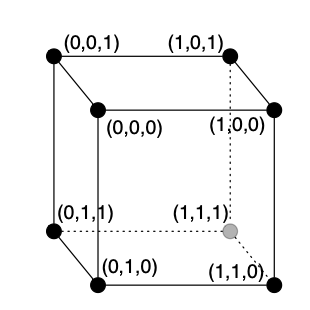

In [64]:
Image(filename='assets/wireframe.png', width=200, height=200) 

In [65]:
# Generate all the points (up to a granularity of 100 per line) that make up the 
# wireframe cube.
L = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0], [0, 0, 1], [1, 0, 1], [0, 1, 1], [1, 1, 1]]
corners = [np.array(v) for v in L]
line_segments = [list(np.linspace(corners[i], corners[j], num=100)) for i,j in
                 [(0,1), (2,3), (0,2), (1,3), (4,5), (6,7), 
                  (4,6), (5,7), (0,4),(1,5),(2,6),(3,7)]]
pts = sum(line_segments, [])
print("Number of total points: " + str(len(pts)))

Number of total points: 1200


In the cell above, we simply generated all the points that make up this wireframe cube, at a granularity of $100$ per line connecting any corner to another corner.

In [66]:
# Check out some of the points
pts[:5]
pts_mat = np.array(pts)

From a different angle, the 3D cube can be plotted with `matplotlib`. You can change `elev` and `azimuth` to a value in `[0, 360]` to get a different angle on the cube. Using `elev=20` and `azimuth=75` gives us approximately the angle of the cube in the image `wireframe.png` above.

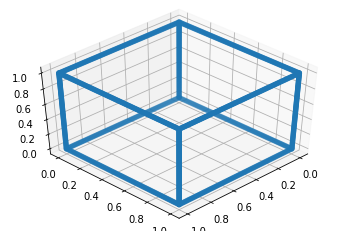

In [67]:
# Plot in 3D
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pts_mat[:,0], pts_mat[:,1], pts_mat[:,2])
elev = 45             # play around with this by changing to a value from 0 to 360
azimuth = 45         # play around with this by changing to a value from 0 to 360
ax.view_init(elev, azimuth)
plt.show()

## Camera Model
Imagine that we are taking a picture of the cube with a camera. The resulting image must depend on *where* we locate the camera and which direction the camera points. Imagine that we have a camera facing straight at the plane containing the front face of the cube. For this exercise, we'll place the camera at the location $[\mathbf{c}]_{\mathcal{W}} = (-1, -1, 8)$ in relation to the cube. If we imagine our perspective from this point, we're 8 units "in front" of the front face of the cube, a bit above and to the left. 

We will use a simplified model of a camera, a *pinhole camera*. We imagine that our *camera center* (the pinhole that the light comes through) is a single point. Photons bounce off objects in the real world scene and travel through this camera center to an *image array*. A photon from the scene only reaches the image array if it travels in a straight line through the camera center. In this model, we imagine that the image array is between the camera center and the scene (instead of behind the camera center, as is the case with most physical cameras).

The image array is located in an affine plane, which we'll call the *image plane*. A photon bounces off some part of an object in the scene (in the picture below, the chin of the frog) and heads in a straight line towards the camera center. On its way to the camera center, it hits the image plane at some point where the photon encounters the image array. That point of contact is then assigned some numeric value dependent on the red, green, and blue light content of the photon, which produces one *pixel* on the image array. A single pixel is a rectangle with a certain color (or shade of gray). Each of the pixels only have *two* coordinates which just denote their placement on the image plane, specifically corresponding to the rectangle's upper-left corner.

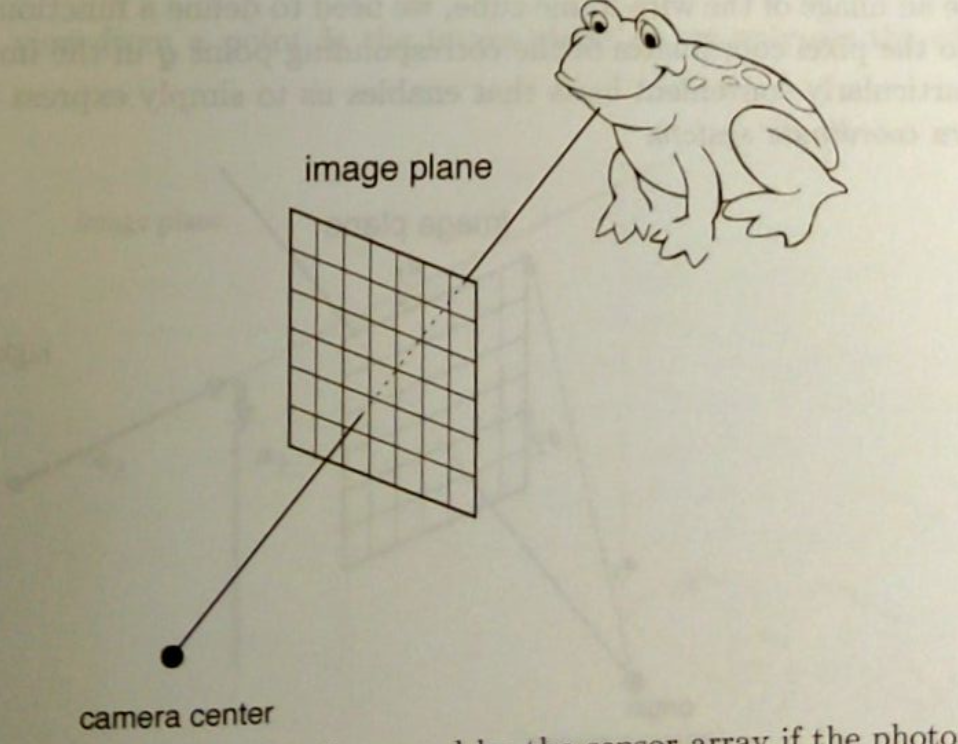

In [68]:
Image(filename='assets/frog.png', width=400, height=400) 

## Camera Coordinates ($\mathcal{A}$) and Pixel Coordinates ($\mathcal{C}$)
Denote some point in the world (belonging to some object in the scene) $\mathbf{p} \in \mathbb{R}^3$. Our goal will be to define a function that maps from points $\mathbf{p}$ in the world to the 2D pixel coordinates of the corresponding point $\mathbf{q}$ in the image plane. To conveniently express this function, we'll introduce another ordered basis $\mathcal{A}$ for $\mathbb{R}^3$ that defines the *camera coordinate system:*

$$\mathcal{A} = (\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3).$$

The first basis vector $\mathbf{a}_1$ goes horizontally from the top-left corner of a pixel to the top-right corner. It controls the horizontal, and is on the image plane. The second basis vector $\mathbf{a}_2$ goes vertically from the top-left corner of a pixel to the bottom-left corner. It controls the vertical, and it is also on the image plane. The third vector $\mathbf{a}_3$ goes from the origin $\mathbf{0}$ to the top-left corner of pixel $(0, 0)$. This vector is *not* on the image plane (it extends from the camera to the image plane).

The third and final basis we introduce is the basis for our *pixel coordinate system,* $\mathcal{C}$, which is actually a basis for $\mathbb{R}^2$:

$$\mathcal{C} = (\mathbf{c}_1, \mathbf{c}_2).$$

We define our pixel coordinate system just in terms of the first two basis vectors of our camera coordinate basis, $\mathcal{A}$, without their third entries.

## Problem 1: Finding $F_3$ (Camera Coordinates $\rightarrow$ Pixels)
Light travels in a straight line from $\mathbf{p}$ to the camera center $\mathbf{0}$ (we assign the origin to the camera center), and, along the way, it intersects the image plane at some point $\mathbf{q} \in \mathbb{R}^3$.

Note the difference between a point's pixel and its camera coordinates. A pixel is a rectangle on the image array canonically denoted by the 2D coordinates of its upper-left corner. Using the *camera coordinate system*, any point $\mathbf{q} \in \mathbb{R}^3$ has coordinates $[\mathbf{q}]_{\mathcal{A}} = (x_1, x_2, x_3)$, so $\mathbf{q} = x_1 \mathbf{a}_1 + x_2 \mathbf{a}_2 + x_3 \mathbf{a}_3$. But, if $\mathbf{q}$ is on the image plane, then the coordinate $x_3$ is simply $1$, and the pixel value of $\mathbf{q}$ on the image array is simply $(x_1, x_2)$. In general, $F_3(x_1, x_2, x_3) = (x_1, x_2)$. This is a simple linear transformation, $F_3: \mathbb{R}^3 \rightarrow \mathbb{R}^2$. We consider representing it from basis $\mathcal{A}$ to $\mathcal{C}.$

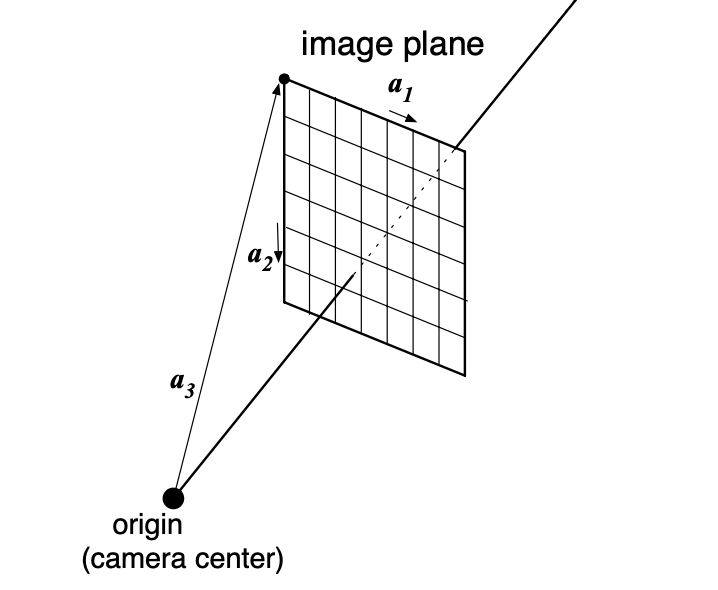

In [69]:
Image(filename='assets/camera_coords.png', width=400, height=400)

We will implement $F_3$ below.

First, implement the function `F3`. The input to `F3` is a `numpy` array of length $3$ for *any* vector $\mathbf{q}$. The output of `F3` is the `numpy` array of length $2$ for the vector $F_3(\mathbf{q})$, where $F_3$ is described above. *Hint:* this should take only one line.

Second, implement the function `F3_mat`. The inputs to `F3_mat` are two `numpy` arrays and a function: `A`, `C`, and `F`. `A` is a $3 \times 3$ `numpy` array designating the matrix for the ordered basis $\mathcal{A} = (\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3)$, with columns in this order. `C` is a $2 \times 2$ `numpy` array designating the matrix for ordered basis $\mathcal{C} = (\mathbf{c}_1$, $\mathbf{c}_2)$. `F` is a function implementing a linear transformation $F: \mathbb{R}^3 \rightarrow \mathbb{R}^2$ (in practice, this will be `F3`, the function you implemented). The output to `F3_mat` is the `numpy` array for the $2 \times 3$ matrix representation of the the linear transformation $F$ with respect to these bases, $[F]_{\mathcal{A} \rightarrow \mathcal{C}}$.

In our camera and pixel example, $\mathbf{c}_1$ and $\mathbf{c}_2$ are specifically defined as $\mathbf{a}_1$ and $\mathbf{a}_2$ witout their last entries. For `F3_mat`, this need not be the case -- it should work for *any* basis $\mathcal{A}$ and basis $\mathcal{C}$.

To implement `F3_mat`, you may find it helpful to use `np.linalg.solve` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)) or `np.linalg.inv` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to determine columns of $[F]_{\mathcal{A} \rightarrow \mathcal{C}}$. You may use either of these functions freely in your implementation.

For `F3_mat`, we have set the default argument for the function `F` as `F3` (this is what the `F=F3` means), so you only need to input `A` and `C` for `F3_mat`. For the test cases below,  both `F3` and `F3_mat` will be tested, but `F3_mat` depends on a correct implementation of `F3`. You may assume that `F3_mat` always uses `F3` when we call it.

In [70]:
def F3(q: np.ndarray) -> np.ndarray:
    """
    Implement the function `F3`, as described above.
    """
    return q[:2]
    
def F3_mat(A, C, F=F3):
    """
    Implement the function `F3_mat`, as described above.
    """
    A_prime = F(A)
    M = np.linalg.solve(C, A_prime)
    return M

In [71]:
q = np.array([0,1,1])
A = np.array([[1/100, 0, 0],
              [0, 1/100, 0],
              [0, 0, 1]])
C = np.array([[1/100, 0],
              [0, 1/100]])
# F3(A)
F3_mat(A, C)

array([[1., 0., 0.],
       [0., 1., 0.]])

In [72]:
grader.check("p1")

p1 results: All test cases passed!

Therefore, $\mathbf{q}$ can be expressed in three ways: 
1. as a point in the world, $[\mathbf{q}]_{\mathcal{W}}$
2. as a point in the image plane, $[\mathbf{q}]_{\mathcal{A}}$
3. or a pixel in the image plane, $[F_3(\mathbf{q})]_{\mathcal{C}}.$

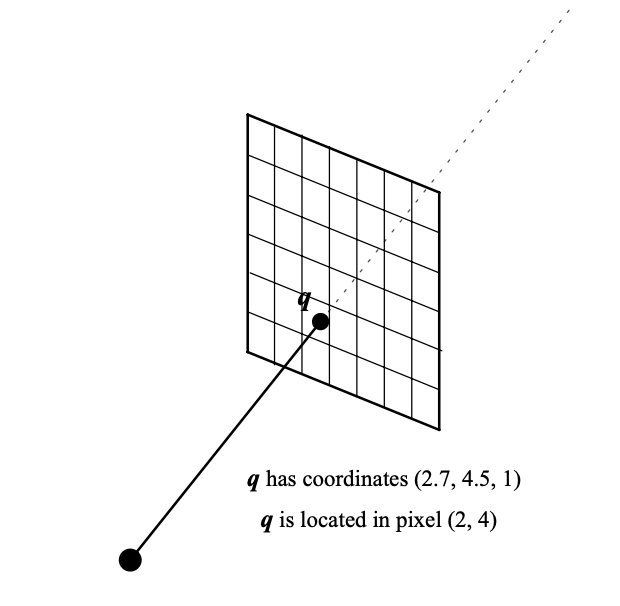

In [73]:
Image(filename='assets/pixels.png', width=400, height=400) 

## Problem 2: Finding $F_2$ ("Projection" onto Image Plane)

Now, we see how to translate from a point in the world (in camera coordinates) to a point in the image plane (also in camera coordinates). Consider the side view of this setup, from a point in the image plane. In this side view, imagine that we are looking directly at the edge of the sensor array. 

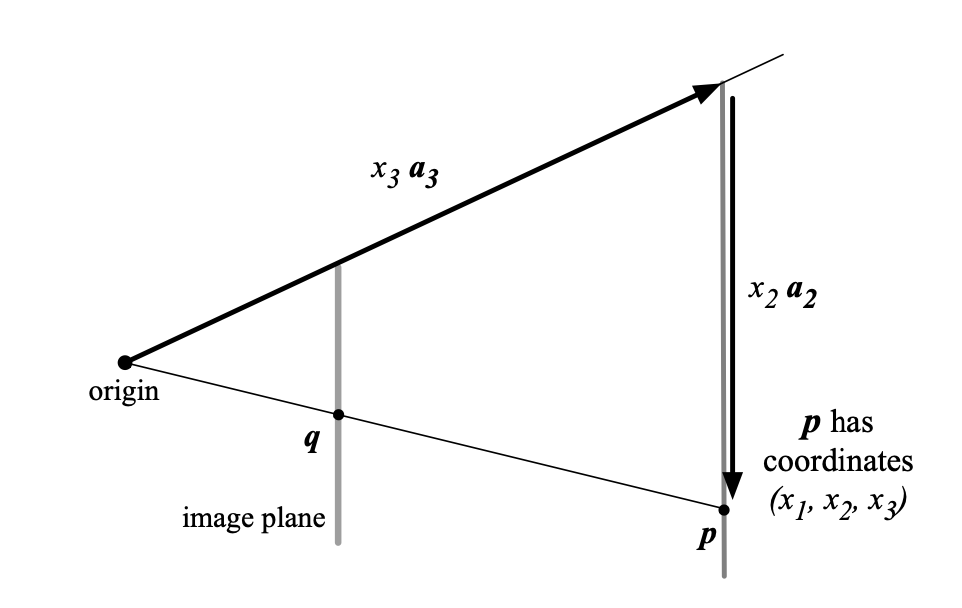

In [74]:
Image(filename='assets/side_view.png', width=400, height=400) 

In this view, we can see the basis vectors $\mathbf{a}_2$ and $\mathbf{a}_3$, but not $\mathbf{a}_1$ because it is pointed directly at us. Now consider $\mathbf{p} \in \mathbb{R}^3$, a point in the scene (this point is *not* on the image plane). We can still find $[\mathbf{p}]_{\mathcal{A}} = (x_1, x_2, x_3)$ in the coordinates of our *camera coordinate system* using the basis $\mathcal{A}$, but $x_3$ will not be $1$, as $\mathbf{p}$ is a point in the world a bit further than our image sensor:

$$\mathbf{p} = x_1 \mathbf{a}_1 + x_2 \mathbf{a}_2 + x_3 \mathbf{a}_3.$$

As is evident from the picture above, $\mathbf{p}$ lives in a plane that is parallel to the image plane. $x_3 \mathbf{a}_3$ is the vector that extends all the way from the origin through the top-left corner of the image array to some point $\mathbf{p}'$ on the plane that $\mathbf{p}$ lives in. $x_2 \mathbf{a}_2$ is the vector that extends from that point $\mathbf{p}'$ to $\mathbf{p}$. $x_1 \mathbf{a}_1$ is the vector that extends horizontally towards us and is not visible. On the picture above, $\mathbf{p}'$ is the top-right corner of the triangle.

Let $\mathbf{q}$ be the point where the line through $\mathbf{p}$ and the origin intersects the image plane. If we look at the triangle formed by the origin, the head of $\mathbf{a}_3$ (with the tail located at the origin), and $\mathbf{q}$, we see that it is just a scaled-down version of the triangle formed by the origin, the head of $x_3 \mathbf{a}_3$, and $\mathbf{p}$. Because these triangles are proportional, we can just use a bit of geometry to conclude that the coordinates of $[\mathbf{q}]_{\mathcal{A}}$ are each just $1/x_3$ times each of the coordinates of $[\mathbf{p}]_{\mathcal{A}}$:

$$\mathbf{q} = (x_1/x_3) \mathbf{a}_1 + (x_2/x_3) \mathbf{a}_2 + \mathbf{a}_3,$$

so $[F_2(\mathbf{p})]_{\mathcal{A}} = [\mathbf{q}]_{\mathcal{A}} = (x_1/x_3, x_2/x_3, 1)$. Therefore, to go from a point in the scene, expressed in camera coordinates, to a point on the image plane, also expressed in camera coordinates, we just need to divide each entry by $x_3$, the third coordinate for $[\mathbf{p}]_{\mathcal{A}}$.

We denote this mapping as $F_2: \mathbb{R}^3 \rightarrow \mathbb{R}^3$, with the rule:
$$F_2(x_1, x_2, x_3) = (x_1/x_3, x_2/x_3, 1).$$
This mapping, unlike $F_3$, is not linear.

Note that, by how we defined our basis $\mathcal{A}$, any object in the scene necessarily has $x_3 > 0$. If $x_3 = 0$, then the object is directly at the camera center, and if $x_3 < 0$, the object is behind the camera. We only care about objects in the scene, so $x_3 > 0$ and dividing by $x_3$ is safe.

Implement the function, `F2` below. The input to `F2` is a `numpy` array, `p` of length $3$, representing $[\mathbf{p}]_{\mathcal{A}}$. You are guaranteed that the third entry of $[\mathbf{p}]_{\mathcal{A}}$ is greater than $0$. The output to `F2` is a `numpy` array of length $3$, the vector $[F_2(\mathbf{p})]_{\mathcal{A}} = [\mathbf{q}]_{\mathcal{A}}.$ *Hint:* This should not take you more than one line.

In [75]:
def F2(p: np.ndarray) -> np.ndarray:
    """
    Implement the function `F2`, as described above.
    """
    return p*(1/p[2])

In [76]:
p = np.array([5, 15, 10])
F2(p)

array([0.5, 1.5, 1. ])

In [77]:
grader.check("p2")

p2 results: All test cases passed!

## Problem 3: Finding $F_1$ (World Coordinates $\rightarrow$ Camera Coordinates) 
We now know two simple mappings, $F_2$ and $F_3$. We know how to map from points $\mathbf{q}$ on our image plane in camera coordinates to pixel coordinates (just choosing the first two coordinates). We also know how to map from points $\mathbf{p}$ in the world in camera coordinates to points $F_2(\mathbf{p}) = \mathbf{q}$ in our image plane, also in camera coordinates. However, the points in our cube were *not* originally given to us in camera coordinates. So, to complete our goal, we need to find a mapping from the points of our cube in their *world coordinate system* (our original representation) to their representation in camera coordinates. In summary, to go from a cube coordinate to a pixel coordinate:

1. $F_1$. *World coordinates* $\rightarrow$ *Camera coordinates* ($\mathcal{W} \rightarrow \mathcal{A}$). Translate world coordinates of a point $[\mathbf{p}]_{\mathcal{W}}$ in the scene (on the cube) to camera coordinates $[\mathbf{p}]_{\mathcal{A}}$. **This is the remaining step.**
2. $F_2$. *Camera coordinates* $\rightarrow$ *Camera coordinates* ($\mathcal{A} \rightarrow \mathcal{A}$). Find the point $[\mathbf{q}]_{\mathcal{A}}$ that corresponds to $[\mathbf{p}]_{\mathcal{A}}$ on the image plane. This mapping is *not* linear.
3. $F_3$. *Camera coordinates* $\rightarrow$ *Pixel coordinates* ($\mathcal{A} \rightarrow \mathcal{C}$). Remove the $x_3$ coordinate from $[\mathbf{q}]_{\mathcal{A}}$ to get the pixel coordinates. This mapping is linear.

For each point $\mathbf{v} \in \mathbb{R}^3$ in the world, we need to obtain its coordinate representation in terms of the camera basis, $[\mathbf{v}]_{\mathcal{A}}$. In this case, we imagine that we have $100$ horizontal pixels and $100$ vertical pixels making up an image sensor array of dimensions $1 \times 1$. Then, $\mathbf{a}_1 = (1/100, 0, 0)$ and $\mathbf{a}_2 = (0, 1/100, 0)$. For $\mathbf{a}_3$, we imagine our camera center as lined up with the center of the sensor array. Remember that $\mathbf{a}_3$ points from the camera center to the top-left corner of the image array, so $\mathbf{a}_3 = (0, 0, 1).$ Therefore, our camera basis $\mathcal{A}$ is:

$$\mathcal{A} = \left(\begin{bmatrix} 1/100 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 1/100 \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}\right).$$

Let us use the standard basis vectors for the world basis, so:
$$\mathcal{W} = \mathcal{E}_3 = \left(\mathbf{e}_1, \mathbf{e}_2, \mathbf{e}_3\right) = \left( \begin{bmatrix}1 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix}0 \\ 1 \\ 0 \end{bmatrix}, \begin{bmatrix}0 \\ 0 \\ 1 \end{bmatrix} \right).$$

For the last mapping, $F_1: \mathbb{R}^3 \rightarrow \mathbb{R}^3$, we need to find the change-of-basis matrix $[\mathrm{id}]_{\mathcal{W} \rightarrow \mathcal{A}}$. Below, you will implement a more general function for changing bases from $\mathcal{E}_3$, the standard basis, to *any* basis $\mathcal{A}$. Then, because $\mathcal{W} = \mathcal{E}_3$ in our example, by inputting the basis vectors for $\mathcal{A}$ as arguments, you will obtain the change-of-basis matrix $[\mathrm{id}]_{\mathcal{E}_3 \rightarrow \mathcal{A}}$.

Implement the function `F1`. The inputs to `F1` are two `numpy` arrays, `points` and `basis`. `points` is a $3 \times n$ matrix, where the columns of the matrix are the $n$ points $[\mathbf{p}]_{\mathcal{E}_3} \in \mathbb{R}^3$ we want to transform to $[\mathbf{p}]_{\mathcal{A}}.$ `basis` is a $3 \times 3$ matrix containing the ordered basis $(\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3)$ in column order. The output to `F1` is a $3 \times n$ matrix, where the columns are $[\mathbf{p}]_{\mathcal{A}}.$ You may freely use `np.linalg.inv` in your solution.

In [78]:
def F1(points, basis):
    """
    Implement `F1`, as described above.
    """
    basis_inv = np.linalg.inv(np.matrix(basis))
    return np.asarray(basis_inv*points) 
    # must convert matrix into ndarray
    # otherwise F2 cannot do p[2]

In [79]:
basis = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
points = np.array([[1],
                   [2],
                   [3]])
F1(points, basis)

array([[1.],
       [2.],
       [3.]])

In [80]:
grader.check("p3")

p3 results: All test cases passed!

## Displaying the Wire-Frame Cube
Now, put this all together to get the pixel coordinates for the wire-frame cube. Before we do anything, we need to account for the shift in origin from world coordinates to camera coordinates. Remember that we located our camera at $(-1, -1, -8)$ in world coordinates. In order to use the camera coordinate system, we need to locate the camera at $(0, 0, 0)$, so translate each of the points of the wire-frame cube by adding $(1, 1, 8)$ to them.

In [81]:
# P_W is the 3x1200 matrix containing each of the points as columns [p]_W
shifted_pts = [v + np.array([1, 1, 8]) for v in pts]
P_W = np.array(shifted_pts).T

First, apply $F_1$ to each $[\mathbf{p}]_{\mathcal{W}}$ to get $[\mathbf{p}]_{\mathcal{A}}$, the points in camera coordinates.

In [82]:
A = np.array([[1/100, 0, 0],
              [0, 1/100, 0],
              [0, 0, 1]])

In [83]:
# Apply F1, the change of basis
P_A = F1(P_W, A)

Second, we apply $F_2$ to $[\mathbf{p}]_{\mathcal{A}}$ in camera coordinates to obtain $[\mathbf{q}]_{\mathcal{A}}$ in the image plane.

In [84]:
# Apply F2, the "projection" onto the image plane
Q_A = np.array([F2(col) for col in P_A.T]).T

Finally, apply $F_3$ to each $[\mathbf{q}]_\mathcal{A}$ to get $[T_3(\mathbf{q})]_{\mathcal{C}}$, the pixel coordinates of the vectors on the image plane.

In [85]:
A = np.array([[1/100, 0., 0.],
              [0., 1/100, 0.],
              [0., 0., 1.]])
C = np.array([[1/100, 0.],
              [0., 1/100]])
Q_C = F3_mat(A, C) @ Q_A

This allows us to plot our wire-frame cube in two dimensions.

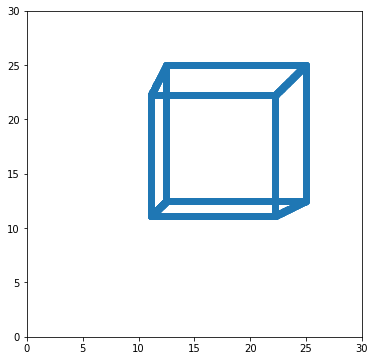

In [86]:
x_val = [col[0] for col in Q_C.T]
y_val = [col[1] for col in Q_C.T]

plt.figure(figsize=(6,6))
plt.xlim([0, 30])
plt.ylim([0, 30])
plt.plot(x_val,y_val,'o')
plt.show()

Note that, in how we originally defined the world coordinates of the cube, increasing the second pixel coordinate corresponded to moving downwards. This was also the case in the camera coordinates. However, `plt.plot` interprets the second coordinate in the usual way (positive means "up"), so the plot is a vertical inversion of what you would see in an image.

Above, we were able to go from points of a wire-frame cube represented in an arbitrary "world coordinate" system to an actual image of the cube that keeps in mind the perspective given by a specific choice of camera placement. We were able to do this by "translating" the world coordinate representation of the points on the cube to a representation in the basis given by the camera coordinate system. We designed this basis to have a seamless translation to pixel values on our image sensor. This meant that the only work we really had to do was a change of basis and figuring out where a straight line from the camera center to our desired point in the world intersects the image sensor. 

## Perspective Rendering for a Duck
Using all the code for **Part 1**, we can do the same thing for more complicated shapes. Below, we define the following duck using $528$ points in $\mathbb{R}^3$. 

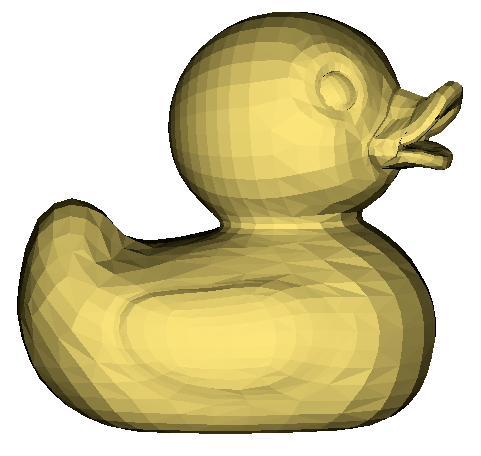

In [87]:
Image(filename='assets/duck.png', width=200, height=200) 

In [88]:
import csv
duck_pts = []
duck_pts_front = []
min_x = -222.8308
max_x = 224.3226
min_y = -207.2948
max_y = 208.3586
min_z = -155.3104
max_z = 156.0546

with open('assets/duck.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        norm_x = (float(row[2]) - min_z)/(max_z - min_z)
        norm_y = (float(row[0]) - min_x)/(max_x - min_x)
        norm_z = (float(row[1]) - min_y)/(max_y - min_y)
        duck_pts.append(np.array([norm_x, norm_y, norm_z]))
        duck_pts_front.append(np.array([norm_y, norm_z, norm_x]))
        
duck_mat = np.array(duck_pts)
duck_mat_front = np.array(duck_pts_front)

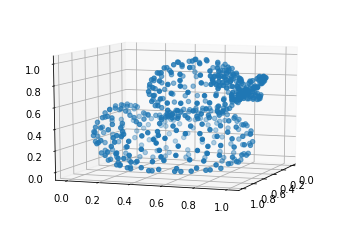

In [89]:
# Plot duck in 3D
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(duck_mat[:,0], duck_mat[:,1], duck_mat[:,2])
elev = 10               # play around with this by changing to a value from 0 to 360
azimuth = 20          # play around with this by changing to a value from 0 to 360
ax.view_init(elev, azimuth)

In [90]:
# P_W is the 3x528 matrix containing each of the points as columns [p]_W
P_W = duck_mat_front + np.array([1, 1, 8])
P_W = P_W.T

A = np.array([[1/100, 0, 0],
              [0, 1/100, 0],
              [0, 0, 1]])

# Apply F1, the change of basis
P_A = F1(P_W, A)

# Apply F2, the "projection" onto the image plane
Q_A = np.array([F2(col) for col in P_A.T]).T
C = np.array([[1/100, 0.],
              [0., 1/100]])

# Apply F3, the change to pixel coordinates
Q_C = F3_mat(A, C) @ Q_A

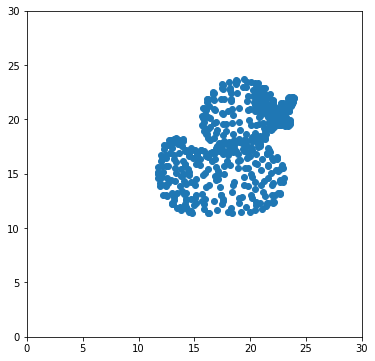

In [91]:
# Plot the duck in 2D
x_val = [col[0] for col in Q_C.T]
y_val = [col[1] for col in Q_C.T]

plt.figure(figsize=(6,6))
plt.xlim([0, 30])
plt.ylim([0, 30])
plt.plot(x_val,y_val,'o')
plt.show()

# Part 2: Perspective Rectification
In **Part 1**, we found the appropriate image for a given set of points, taking into the account the perspective from a fixed camera. The goal for this main part of the lab is the opposite: we want to *remove* perspective from an image of a flat surface. Essentially, we want to synthesize a new image that completely lacks the perspective imbued from how we took the image, but shows us the flat surface (in this case, a whiteboard) head-on. 

The specific image we will be playing with will be `board.png`, included in your `assets` directory.

In order to do this, we will again have to use different coordinate systems and a change of basis. Think of the original image as a grid of rectangles that are each assigned a color (the pixels). Each of these pixels corresponds to a parallelogram in the plane of the whiteboard. To get the perspective-free image, we must assign each of these parallelograms the corresponding color from the rectangle in the original image.

Our goal is thus to find a function that maps from pixel coordinates (the coordinates of a point in our image `board.png`) to coordinates that exist in the plane of the whiteboard. It is already clear that we will be dealing with *two* coordinate systems: the coordinate system for the image, and the coordinate system for the whiteboard. 

In [92]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

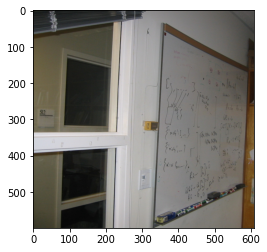

In [93]:
img = mpimg.imread('assets/board.png')
imgplot = plt.imshow(img)

At the end of the assignment, you should see the whiteboard head on, with perspective removed. Here's a "spoiler" cell that shows what you should see at the end, `board_final.png`. If you don't want spoilers, you can skip the following cell until the end and just use it to check your final image. If you do want to see what should happen at the end, uncomment the line of code `Image(filename='asserts/board_final.png')` below.

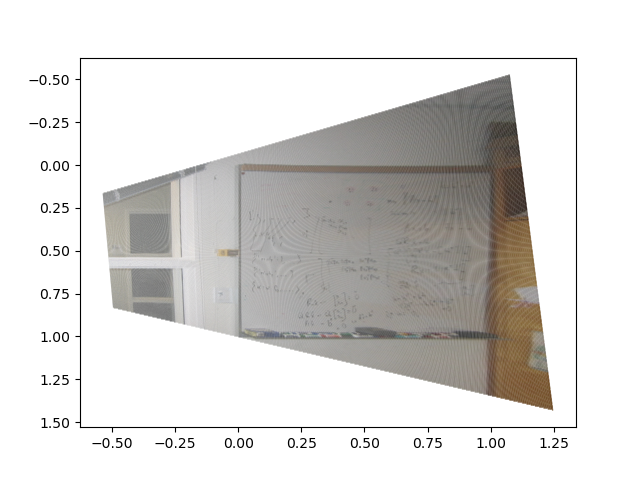

In [128]:
# THIS CELL IS A *SPOILER*!
Image(filename='assets/board_final.png') 

## The Two Bases: Camera Basis and Whiteboard Basis
We will be using two bases here: the **camera basis** and the **whiteboard basis**. 

We will denote the **camera basis** as $\mathcal{A} = (\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3)$, defined similarly to how we defined the camera coordinate system in the **Part 1**. In the camera basis:
- The origin is the camera center.
- The vector $\mathbf{a}_1$ goes horizontally from the top-left corner of the top-left pixel to the top-right corner.
- The vector $\mathbf{a}_2$ goes vertically from the top-left corner of the top-left pixel to the bottom-left corner.
- The vector $\mathbf{a}_3$ goes from the origin (the camera center) to the top-left corner of the top-left pixel.

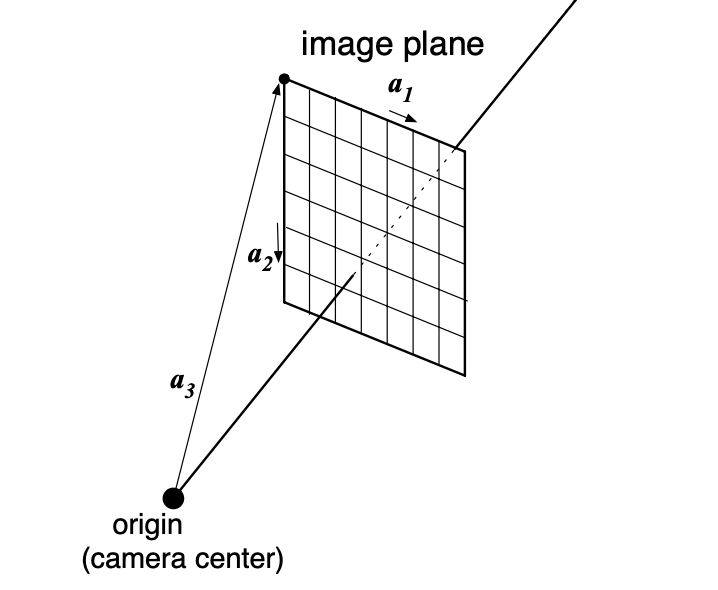

In [95]:
Image(filename='assets/camera_coords.png', width=400, height=400) 

We denote the **whiteboard basis** as $\mathcal{W} = (\mathbf{c}_1, \mathbf{c}_2, \mathbf{c}_3)$. Instead of defining the basis vectors with respect to the plane given by the image array, we define the basis vectors with respect to the plane given by the whiteboard. In the whiteboard basis:

- The origin is the camera center.
- The vector $\mathbf{c}_1$ goes horizontally from the top-left corner of the whiteboard to the top-right corner (it extends the entire horizontal length of the whiteboard).
- The vector $\mathbf{c}_2$ goes vertically from the top-left corner of the whiteboard to the bottom-left corner (it extends the entire vertical length of the whiteboard).
- The vector $\mathbf{c}_3$ goes from the origin (camera center) to the top-left corner of the whiteboard.

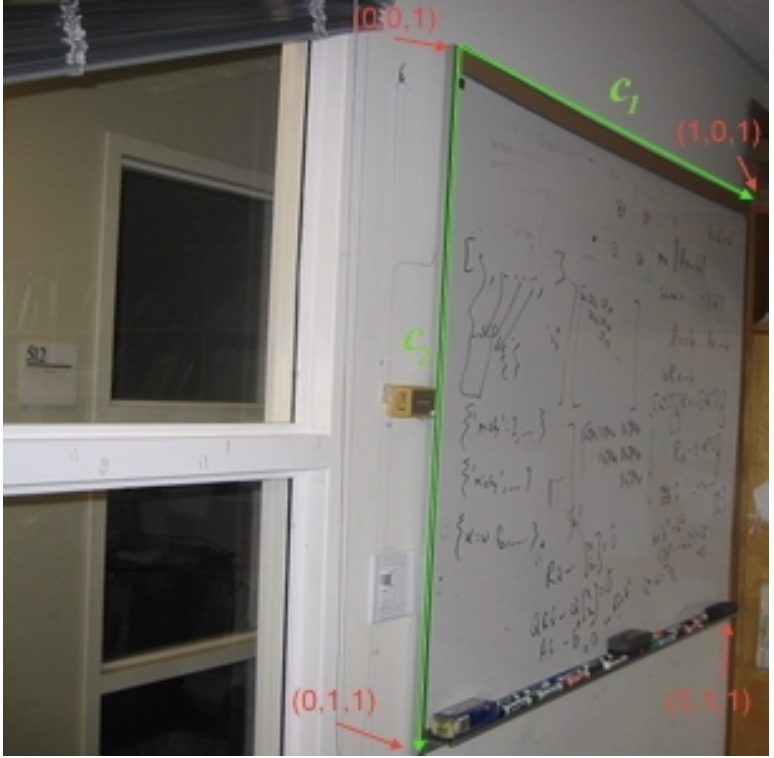

In [96]:
Image(filename='assets/whiteboard_coords.png', width=400, height=400) 

## Overview: How to Map from Pixels to Whiteboard Points
Remember that our goal is to find a function that maps from the representation of a point in camera coordinates in the image plane to the representation of the same point in whiteboard coordinates in the whiteboard plane. It is clear that we will have to, at some point, use a change of basis from $\mathcal{A} = (\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3)$ to $\mathcal{W} = (\mathbf{c}_1, \mathbf{c}_2, \mathbf{c}_3)$.

One thing to note is that we would like our final point to be the point *in the whiteboard plane*! It is not sufficient just to find the point we desire in whiteboard coordinates because, in the end, we are actually looking for the representation of points in 2D -- we are interested in displaying an image, after all. So, even after we do a change of basis to find the point in whiteboard coordinates, we need an additional projection step to get the point on the whiteboard plane.

The following is an overview of the entire procedure. Starting from `board.png`, we have the *pixel coordinates* of points, in the basis $\mathcal{C} = (\mathbf{a}_1', \mathbf{a}_2')$, where $\mathbf{a}_1', \mathbf{a}_2' \in \mathbb{R}^2$ are simply $\mathbf{a}_1$ and $\mathbf{a}_2$ without their third coordinates. Luckily, it is easy to go from pixel coordinates to camera coordinates -- we defined $\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3$ such that if we have a point in `board.png` with pixel coordinates $(x_1, x_2)$, that same point has camera coordinates $(x_1, x_2, 1)$. Thus, *we already have a transformation from pixel coordinates to camera coordinates*. Call this (nonlinear) function $T_1: \mathbb{R}^2 \rightarrow \mathbb{R}^3$.

Also, if we have a point $\mathbf{p}$ in whiteboard coordinates, $[\mathbf{p}]_{\mathcal{W}}$, we can follow the same argument as **Finding $F_2$** in **Part 1** to get $[\mathbf{q}]_{\mathcal{W}}$, the corresponding point in the whiteboard plane (also in whiteboard coordinates). If $[\mathbf{p}]_\mathcal{W} = (x_1, x_2, x_3)$ in whiteboard coordinates, then $[\mathbf{q}]_\mathcal{W} = (x_1/x_3, x_2/x_3, 1)$, the projection of the point in space onto the whiteboard plane. So we *also already have a transformation from points in space to points in the whiteboard plane (in whiteboard coordinates)*. Call this (nonlinear) function $T_3: \mathbb{R}^3 \rightarrow \mathbb{R}^3$. For our purposes, $T_3 = F_2$, from above.

In summary, we start with some pixel $(x_1, x_2)$ in `board.png`, which corresponds to a vector $\mathbf{p}$ in the vector space $\mathbb{R}^3$. With $T_1$, we can translate this to $\mathbf{p} = x_1 \mathbf{a}_1 + x_2 \mathbf{a}_2 + \mathbf{a}_3$, the representation of $\mathbf{p}$ in the camera basis, written $[\mathbf{p}]_\mathcal{A}= (x_1, x_2, 1)$. If we knew the vector representation of $\mathbf{p}$ in the whiteboard basis, $[\mathbf{p}]_\mathcal{W} = (y_1, y_2, y_3)$, then we could find its projection $[\mathbf{q}]_\mathcal{W}$ in the whiteboard plane by $T_3$. So, what's missing? The step in the middle: we need to be able to map from $[\mathbf{p}]_\mathcal{A}$ to $[\mathbf{p}]_\mathcal{W}$. That is, we need to be able to map from any point in camera coordinates to any point in whiteboard coordinates.

Our goal is to find the linear function $T_2: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ such that:

- **Input:** the coordinate representation $(x_1, x_2, x_3)$ of a point $[\mathbf{p}]_{\mathcal{A}}$ in terms of camera coordinates.
- **Output:** the coordinate representation $(y_1, y_2, y_3)$ of the point $[\mathbf{p}]_{\mathcal{W}}$ in terms of whiteboard coordinates.

Of course, this will be given by a change-of-basis matrix.

Then, going from pixels to $[\mathbf{q}]_{\mathcal{W}}$ in the whiteboard plane is simply the composition of three functions: $T_3 \circ T_2 \circ T_1: \mathbb{R}^2 \rightarrow \mathbb{R}^3$.

## Problem 4: Finding $T_1$ (Pixel $\rightarrow$ Camera Coordinates)
$T_1: \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is the function $T_1(x_1, x_2) = (x_1, x_2, 1)$. We will use this to map from pixel values to camera coordinates. We will be using it on points $\mathbf{p}' \in \mathbb{R}^2$ in pixel coordinates, i.e. $T_1([\mathbf{p}']_\mathcal{C}) = [\mathbf{p}]_{\mathcal{A}}$. This should, in a sense, "invert" `F3`, which you implemented in **Part 1**.

Implement `T1`, as described above. The input to `F1` is `p`, a `numpy` array of length $2$ representing the pixel coordinates $[\mathbf{p}']_{\mathcal{C}}$. The output to `F` is a `numpy` array of length $3$ representing the camera coordinates $T_1([\mathbf{p}']_{\mathcal{C}}) = [\mathbf{p}]_{\mathcal{A}}$. *Hint:* This should only take one line.

In [97]:
def T1(p: np.ndarray) -> np.ndarray:
    '''
    Implement the function `T1`, as described above.
    '''
    return np.append(p, 1)

In [98]:
grader.check("p4")

p4 results: All test cases passed!

## Finding $T_3$ ("Projection" onto Whiteboard Plane)
Now, we find the function for $T_3$, which maps from a point $[\mathbf{p}]_{\mathcal{W}}$ in the world to a corresponding point $[\mathbf{q}]_{\mathcal{W}}$ on the whiteboard plane.

Suppose, first, that $\mathbf{p}$ is a point *on* the whiteboard or whiteboard plane. Then, by how we defined the whiteboard basis, we can write $\mathbf{p}$ as $\mathbf{p} = x_1 \mathbf{c}_1 + x_2 \mathbf{c}_2 + \mathbf{c}_3$, or $[\mathbf{p}]_\mathcal{W} = (x_1, x_2, 1)$. We know that a point is already *on* the whiteboard plane if its last coordinate is $1$.

Suppose, instead, that $\mathbf{p}$ is a point *not on* the whiteboard or whiteboard plane. We can't see behind the whiteboard plane in the image, so it must be a point closer to the camera. This must mean that its $x_3$ coordinate is less than $1$. Consider the line through the origin (camera center) and $\mathbf{p}$. This line intersects the whiteboard plane at a point $\mathbf{q}$. Necessarily, $\mathbf{q}$ is a point *on* the whiteboard plane, with $x_3 = 1$ and $(x_1, x_2)$ describing $\mathbf{q}$'s place on the plane with respect to the whiteboard basis vectors.

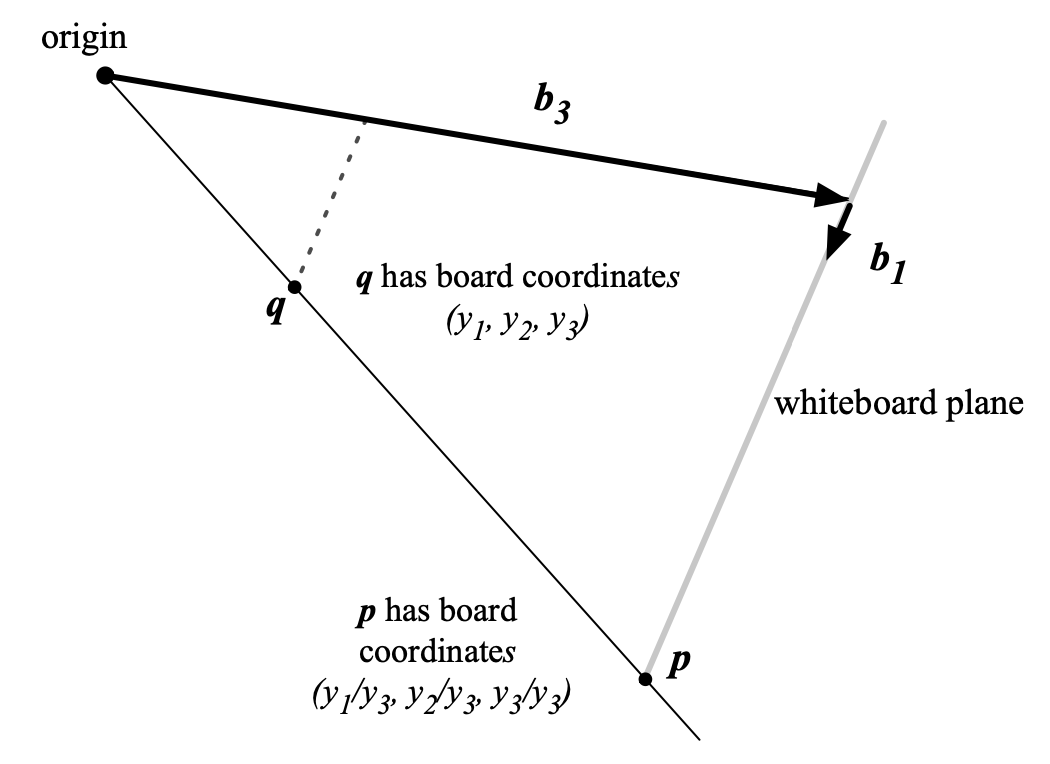

In [99]:
Image(filename='assets/top_t3.png', width=400, height=400) 

The view for the image above is looking from the ceiling down at the whiteboard. We do not see basis vector $\mathbf{c}_2$ because it points downward, in the same direction as our gaze. $\mathbf{c}_1$ (labeled $\mathbf{b}_1$ in the image) is the vector along the top edge of the whiteboard and $\mathbf{c}_3$ (labeled $\mathbf{b}_3$ in the image) goes from the camera center to the top-left of the board, where $\mathbf{c}_1$'s tail is. By similar triangles, we know that if $[\mathbf{p}]_\mathcal{W} = (x_1, x_2, x_3)$, then $[\mathbf{q}]_\mathcal{W} = (x_1/x_3, x_2/x_3, 1)$. 

There is one subtlety here, however. If $\mathbf{p}$ is a point in the plane parallel to the whiteboard plane containing the camera center, then $y_3 = 0$. However, if this were the case, our model of the camera would not be able to capture $\mathbf{p}$ in the first place. Our camera center only captures what is "in front" of it, where $x_3 > 0$. Thus, we can safely assume that $x_3 > 0$ for all $\mathbf{p}$ we care about.

Notice, however, that we've already implemented a function that does exactly that in **Part 1**! This was `F2`. As to not repeat work, we will just have `T3` below call `F2`, with the same arguments.

The input to `T3` is a `numpy` array, `p` and a function, `F`. `p` is length $3$, representing $[\mathbf{p}]_{\mathcal{W}}$. The function `F` will be, by default, set to `F2`. We are guaranteed that the third entry of $[\mathbf{p}]_{\mathcal{W}}$ is greater than $0$. The output to `T3` is a `numpy` array of length $3$, the vector $[T_3(\mathbf{p})]_{\mathcal{W}} = [\mathbf{q}]_{\mathcal{W}}.$

In [100]:
def T3(p, F=F2):
    '''
    T3 just calls F2, implemented above.
    '''
    return F(p)

## $T_2$: Camera to Whiteboard Coordinates (Change of Basis)
Finally, we need to develop a procedure for changing from camera basis to whiteboard basis.

Suppose we want to write $\mathbf{p}$ in terms of the camera basis $\mathcal{A} = (\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3)$ and the whiteboard basis $\mathcal{W} = (\mathbf{c}_1, \mathbf{c}_2, \mathbf{c}_3)$. We would like to translate from $[\mathbf{p}]_{\mathcal{A}}$ to $[\mathbf{p}]_{\mathcal{W}}$.

To do this, we must find a $3 \times 3$ change-of-basis matrix, $C := [\mathrm{id}]_{\mathcal{A} \rightarrow \mathcal{W}}$. We know from class that this will look like:

$$C = [\mathrm{id}]_{\mathcal{A} \rightarrow \mathcal{W}} = \begin{bmatrix} \uparrow & \uparrow & \uparrow \\ [\mathbf{a}_1]_{\mathcal{W}} & [\mathbf{a}_2]_{\mathcal{W}} & [\mathbf{a}_3]_{\mathcal{W}} \\ \downarrow & \downarrow & \downarrow \end{bmatrix}.$$

Then, we can apply $C$ as follows:

$$C [\mathbf{p}]_{\mathcal{A}} = [\mathbf{p}]_{\mathcal{W}}.$$

But how can we find $C$ if do not know the camera basis or whiteboard basis *a priori*, as in this case?

## Finding $T_2$ By Solving a Linear System
Instead, we will try to find $C$ by observing how $C$ behaves on known points, setting up a linear system based on these observations, and solving the linear system to find $C$'s entries. We will walk you through this process, but it will be up to you to implement this in code.

Write $C = \begin{bmatrix} c_{1, 1} & c_{1, 2} & c_{1, 3} \\ c_{2, 1} & c_{2, 2} & c_{2, 3} \\ c_{3, 1} & c_{3, 2} & c_{3, 3} \end{bmatrix}$. Let $\mathbf{p}$ be some point in the image we're interested in. If $\mathbf{p}$ is the top-left corner of the pixel at $(x_1, x_2)$, for instance, then $\mathbf{p}$ has camera coordinates $[\mathbf{p}]_\mathcal{A} = (x_1, x_2, 1)$, and, because $C[\mathbf{p}]_{\mathcal{A}} = [\mathbf{p}]_{\mathcal{W}}$:

$$ \begin{bmatrix} c_{1, 1} & c_{1, 2} & c_{1, 3} \\ c_{2, 1} & c_{2, 2} & c_{2, 3} \\ c_{3, 1} & c_{3,2} & c_{3,3} \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ 1 \end{bmatrix} = \begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix},$$

where $(y_1, y_2, y_3)$ are the whiteboard coordinates of $\mathbf{p}$, i.e. $[\mathbf{p}]_\mathcal{W} = (y_1, y_2, y_3)$. Multiplying out, we obtain the equations:

\begin{align}
c_{1, 1} x_1 + c_{1, 2} x_2 + c_{1, 3} = y_1\\
c_{2,1} x_1 + c_{2, 2} x_2 + c_{2, 3} = y_2\\
c_{3,1} x_1 + c_{3,2} x_2 + c_{3, 3} = y_3.
\end{align}

If we know the coordinates of some point $\mathbf{p}$ in both camera coordinates, $[\mathbf{p}]_{\mathcal{A}}$, and whiteboard coordinates, $[\mathbf{p}]_{\mathcal{W}}$, we can plug in $(x_1, x_2, 1)$ and $(y_1, y_2, y_3)$ into the above three linear equations and get three equations in nine unknowns.

For example, suppose consider some pixel on the whiteboard at $(329, 597)$. Then, $x_1 = 329, x_2 = 597,$ and $x_3 = 1$ in camera coordinates, i.e. $[\mathbf{p}]_\mathcal{A} = (x_1, x_2, x_3) = (329, 597, 1)$. Plug these values into the equations above and we get:

\begin{align}
329c_{1, 1} + 597c_{1, 2} + c_{1, 3} = y_1\\
329c_{2,1} + 597c_{2, 2} + c_{2, 3} = y_2\\
329c_{3,1} + 597c_{3,2} + c_{3, 3} = y_3.
\end{align}

However, the problem is that we don't know the whiteboard coordinates for all points, $[\mathbf{p}]_{\mathcal{W}} = (y_1, y_2, y_3)$, immediately. But we do know for a select few of our points, due to how we constructed our bases; namely, the points *on the whiteboard!* For example, take $\mathbf{p}$ to be the bottom-left corner of the whiteboard, at $[\mathbf{p}]_{\mathcal{A}} = (329, 597, 1)$. We know from how we constructed our whiteboard basis that $[\mathbf{p}]_{\mathcal{W}} = (0, 1, 1)$.

Plugging these in with our three equations above and rearranging, we obtain two linear equations in the unknowns of $C$:

\begin{align}
&329c_{1, 1} + 597c_{1, 2} + c_{1, 3} = 0\\
&329c_{2,1} + 597c_{2, 2} + c_{2, 3} - 329c_{3,1} - 597c_{3,2} - c_{3, 3} = 0.
\end{align}

Using the other three corners of the whiteboard, we could get a total of six more equations.

Consider a corner of the whiteboard, denoted $\mathbf{p}$. Then, $[\mathbf{p}]_\mathcal{A} = (x_1, x_2, 1)$ has a representation $[\mathbf{p}]_{\mathcal{W}} = (y_1, y_2, y_3)$ in whiteboard coordinates. Because $\mathbf{p}$ is on the whiteboard plane, $y_3 = 1$, and $y_1, y_2 \in \{0, 1\}$ because it's a corner. Applying the change-of-basis $C[\mathbf{p}]_{\mathcal{A}} = [\mathbf{p}]_{\mathcal{W}}$,

$$
\begin{align}
c_{1, 1} x_1 + c_{1, 2} x_2 + c_{1, 3} &= y_1\\
c_{2,1} x_1 + c_{2, 2} x_2 + c_{2, 3} &= y_2\\
c_{3,1} x_1 + c_{3,2} x_2 + c_{3, 3} &= 1.
\end{align}
$$

Multiplying the last equation with $y_1$ or $y_2$ yields the two equations:

$$
\begin{align}
(x_1y_1) c_{3,1} + (x_2y_1) c_{3,2} + y_1c_{3, 3} &= y_1\\
(x_1y_2)c_{3,1} + (x_2y_2)c_{3,2} + y_2c_{3, 3} &= y_2\\
\end{align}
$$

Therefore, we obtain two equations:
$$
\begin{equation}
x_1c_{1, 1} + x_2c_{1, 2} + c_{1, 3} - (x_1y_1)c_{3,1} - (x_2y_1)c_{3,2} - y_1c_{3, 3} = 0 \label{eq:eq1} \tag{1}
\end{equation}
$$

and:
$$
\begin{equation}
x_1c_{2,1} + x_2c_{2, 2} + c_{2, 3} - (x_1y_2)c_{3,1} - (x_2y_2)c_{3,2} - y_2c_{3, 3} = 0 \label{eq:eq2} \tag{2}.
\end{equation}
$$

To simplify notation, consider vectors from mapping pairs of whiteboard points $([\mathbf{p}]_{\mathcal{A}}, [\mathbf{p}]_{\mathcal{W}})$, where $[\mathbf{p}]_{\mathcal{A}} = (x_1, x_2, 1)$ and $[\mathbf{p}]_{\mathcal{W}} = (y_1, y_2, y_3)$, to $(x_1 y_1, x_1 y_2, x_1 y_3, x_2y_1, \dots, x_3 y_3) \in \mathbb{R}^9$. Then, we can write the two equations above as row-column matrix products (i.e. dot products), with coefficient vectors $\mathbf{u}, \mathbf{v}$ and unknown entries $\mathbf{c}$ all in $\mathbb{R}^9$:

\begin{align}
\mathbf{u}^T \mathbf{c} = 0\\
\mathbf{v}^T \mathbf{c} = 0.
\end{align}

In the products above, we assume that $\mathbf{c}$ is written in row-major form, i.e. $\mathbf{c} = (c_{1,1}, c_{1,2}, c_{1,3}, c_{2,1}, c_{2,2}, c_{2,3}, c_{3,1}, c_{3,2}, c_{3,3}) \in \mathbb{R}^9$. Given $([\mathbf{p}]_{\mathcal{A}}, [\mathbf{p}]_{\mathcal{W}})$, we can find the appropriate coefficients and store them in $\mathbf{u}$ and $\mathbf{v}$, our coefficient vectors. We implement this below.

## Problem 5: Finding Coefficient Vectors $\mathbf{u}$ and $\mathbf{v}$
Below, we will implement `make_equations`, which should output the coefficient vectors $\mathbf{u}, \mathbf{v} \in \mathbb{R}^9$ described above. The coefficients should correspond to equations $(1)$ and $(2)$ above:

$$
\begin{equation}
x_1c_{1, 1} + x_2c_{1, 2} + c_{1, 3} - (x_1y_1)c_{3,1} - (x_2y_1)c_{3,2} - y_1c_{3, 3} = 0 \\
x_1c_{2,1} + x_2c_{2, 2} + c_{2, 3} - (x_1y_2)c_{3,1} - (x_2y_2)c_{3,2} - y_2c_{3, 3} = 0.
\end{equation}
$$

The inputs to `make_equations` are the `numpy` arrays `p_A` and `p_W`. `p_A` represents the coordinates $[\mathbf{p}]_{\mathcal{A}} = (x_1, x_2, x_3)$, and `p_W` represents the coordinates $[\mathbf{p}]_{\mathcal{W}} = (y_1, y_2, y_3)$. The output to `make_equations` is a `tuple` of two `numpy` arrays, `u` and `v`. The first entry of the tuple, `u`, is a `numpy` array that contains the $9$ coefficients for the first equation above, stored in $\mathbf{u} \in \mathbb{R}^9$. The second entry of the tuple, `v`, is a `numpy` array that contains the $9$ coefficients for the second equation, stored in $\mathbf{v} \in \mathbb{R}^9$.

In [101]:
def make_equations(p_A: np.ndarray, p_W: np.ndarray) -> tuple:
    '''
    Implement `make_equations`, as described above.
    '''
    # u, v are coeffienient x and y instead of c
    u = np.zeros(9)
    v = np.zeros(9)
    u[0] = p_A[0]
    u[1] = p_A[1]
    u[2] = 1
    u[6] = (-1) * p_A[0] * p_W[0]
    u[7] = (-1) * p_A[1] * p_W[0]
    u[8] = (-1) * p_W[0]
    v[3] = p_A[0]
    v[4] = p_A[1]
    v[5] = 1
    v[6] = (-1) * p_A[0] * p_W[1]
    v[7] = (-1) * p_A[1] * p_W[1]
    v[8] = (-1) * p_W[1]
    return (u, v)

In [102]:
grader.check("p5")

p5 results: All test cases passed!

If we use the four corners of the whiteboard, we get eight equations. However, no matter how many points we use, we cannot hope to pin down $C$ exactly using only input-output pairs. Why? 

Suppose $\hat{C}$ were a matrix that satisfied all the equations: for any input vector $\mathbf{x} = (x_1, x_2, 1)$, we have $T_2(\mathbf{x}) = \hat{C} \mathbf{x}$, as desired. For any scalar $\alpha$, we know that $(\alpha \hat{C})\mathbf{x} = \alpha (\hat{C} \mathbf{x})$. Suppose that $\hat{C} \mathbf{x} = (y_1, y_2, y_3)$. Then, $\alpha(\hat{C}\mathbf{x}) = (\alpha y_1, \alpha y_2, \alpha y_3)$. However, we are concerned, in the end, with $T_2' = T_3 \circ T_2(\mathbf{x})$, and since $T_3$ divides the first and second entries by the third, multiplying all entries by $\alpha$ does not change the output of $T_3$:

$$T_2'(\alpha \mathbf{x}) = T_3(T_2(\mathbf{\alpha x})) = T_3(\alpha (\hat{C} \mathbf{x})) = T_3(\alpha y_1, \alpha y_2, \alpha y_3) = (y_1/y_3, y_2/y_3, 1) = T_3(y_1, y_2, y_3) = T_2'(\mathbf{x}).$$

This shows that, for our purposes, if $\hat{C}$ is a suitable matrix for $C$ then so is $\alpha \hat{C}$. This result corresponds to the fact that we cannot recover the scale of the whiteboard from the image. We might be looking at a huge whiteboard very far away, or a tiny whiteboard very up close. Regardless, this doesn't matter to the function $T_2'$. 

Thus, in order to pin down *some* matrix $C$, it suffices to impose a scaling equation. We just require that *some* entry, say, $c_{1,1}$, equal to 1. We can write this as $\mathbf{w} \cdot \mathbf{c} = 1$, where $\mathbf{w} = (1, 0, \dots, 0) \in \mathbb{R}^9$ is the coefficient vector. The corresponding equation is:
$$c_{1,1} = 0.$$

In [103]:
w = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])

## Problem 6: Finding $C$ (Change of Basis Matrix) and $T_2$

Now, it's time to find the matrix $C$.

We'll setup a system of 9 linear equations, in matrix vector form. Let $L$ be the $9 \times 9$ matrix, whose rows are, in order: the four pairs of vectors $\mathbf{u}$ and $\mathbf{v}$ from applying `make_equations` to the four corners of the board and finally the vector $\mathbf{w}$ from above (top-left, bottom-left, top-right, then bottom-right). We solve for $\mathbf{c} = (c_{1,1}, c_{1,2}, c_{1,3}, c_{2,1}, c_{2,2}, c_{2,3}, c_{3,1}, c_{3,2}, c_{3,3}) \in \mathbb{R}^9$, the entries of $C$. The system is:

$$L \mathbf{c} = \mathbf{b},$$

where $\mathbf{b}$ is the vector with all zero entries except for the last one, which should be $1$ per our scaling constraint. After solving the above equation for $\mathbf{c} \in \mathbb{R}^9$, we can reshape $\mathbf{c}$ into a matrix again to recover the $3 \times 3$ matrix:

$$C = \begin{bmatrix} c_{1, 1} & c_{1, 2} & c_{1, 3} \\ c_{2, 1} & c_{2, 2} & c_{2, 3} \\ c_{3, 1} & c_{3, 2} & c_{3, 3} \end{bmatrix}.$$

Then, because $C = [T_2]_{\mathcal{A} \rightarrow \mathcal{W}}$, the function $T_2$ is implemented by simply matrix multiplying by $C$:
$$
T_2([\mathbf{p}]_{\mathcal{A}}) = C[\mathbf{p}]_{\mathcal{A}} = [T_2]_{\mathcal{A} \rightarrow \mathcal{W}}[\mathbf{p}]_{\mathcal{A}} = [\mathbf{p}]_{\mathcal{W}}.
$$

Implement the function `change_of_basis_T2` below. The inputs to `change_of_basis_T2` are `topleft`, `botleft`, `topright`, `botright`, `make_equations_fn`, and `ninth_eq`. `topleft` (similarly, `botleft`, `topright`, and `botright`) is a tuple of length $2$ that has $[\mathbf{p}]_{\mathcal{A}}$ as its first entry and $[\mathbf{p}]_{\mathcal{W}}$ as its second entry, where $\mathbf{p}$ is the top-left corner of the whiteboard (similarly, bottom-left, top-right, and bottom-right). `make_equations_fn` is the funciton that outputs the coefficient vectors $\mathbf{u}$ and $\mathbf{v}$; by default, it is set to `make_equaitons`, which was implemented in **Problem 5**. `ninth_eq` gives the coefficient vector $\mathbf{w}$ for the ninth equation in the system (the last row in $L$). By default, it is set to `w`, which was fixed above to be `np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])`. The output of `change_of_basis_T2` is a `numpy` array `C` for the $3 \times 3$ change-of-basis matrix $C = [T_2]_{\mathcal{A} \rightarrow \mathcal{W}}$, described above.

You may use `np.linalg.solve` to solve the system of equations. You will also likely need to use `np.reshape`. Be careful to make sure that `np.reshape` is reshaping in row-major form; to do this to some vector `v`, specify `order='C'` as an argument, i.e. `np.reshape(v, new_shape, order='C')`, where `new_shape` is the `tuple` for the new shape of `v`.

In [104]:
w = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
def change_of_basis_T2(topleft: tuple, botleft: tuple, topright: tuple, botright: tuple, 
                       make_equations_fn=make_equations, ninth_eq=w) -> np.ndarray:
    '''
    Implement the function `change_of_basis_T2`, described above.
    '''
    (u_tl, v_tl) = make_equations_fn(topleft[0], topleft[1])
    (u_bl, v_bl) = make_equations_fn(botleft[0], botleft[1])
    (u_tr, v_tr) = make_equations_fn(topright[0], topright[1])
    (u_br, v_br) = make_equations_fn(botright[0], botright[1])
    
    L = np.row_stack((u_tl, v_tl, u_bl, v_bl, u_tr, v_tr, u_br, v_br, w))
    b = np.array([0,0,0,0,0,0,0,0,1]).T
    C_row = np.linalg.solve(L, b)
    C = np.reshape(C_row, (3,3), order='C')
    return C

Note: the test cases below don't correspond to actual corners on any image; they are merely convenient inputs that test if your `change_of_basis_T2` is correctly solving the system $L\mathbf{c} = \mathbf{b}$ described above.

In [106]:
grader.check("p6")

p6 results: All test cases passed!

In [107]:
# If we know C, then the transformation T2 is just a matrix multiplication
def T2(C: np.ndarray, p: np.ndarray) -> np.ndarray:
    return C @ p

## Putting it all together: Perspective-less Image
Recall that our initial goal was to find a function that maps from the representation of a point in camera coordinates in the image plane to the representation of the same point in whiteboard coordinates in the whiteboard plane. We denoted this as $T_3 \circ T_2 \circ T_1: \mathbb{R}^2 \rightarrow \mathbb{R}^3$.

- $T_1: \mathbb{R}^2 \rightarrow \mathbb{R}^3$: This translated from pixel coordinates $(x_1, x_2)$ to camera coordinates $(x_1, x_2, 1)$.
- $T_2: \mathbb{R}^3 \rightarrow \mathbb{R}^3$: This was a change of basis from camera coordinates $[\mathbf{p}]_{\mathcal{A}} = (x_1, x_2, x_3)$ to whiteboard coordinates $[\mathbf{p}]_{\mathcal{W}} = (y_1, y_2, y_3)$.
- $T_3: \mathbb{R}^3 \rightarrow \mathbb{R}^3$: This was a "projection" of any point in whiteboard coordinates, $[\mathbf{p}]_{\mathcal{W}}$, onto the whiteboard plane $[\mathbf{q}]_{\mathcal{W}} = (y_1/y_3, y_2/y_3, 1)$.

All that remains is to apply this to all points in the image and display the resulting "perspective-less" image. How do we do this?

First, we load up the image into an array of shape $(\text{width}, \text{height}, 3)$, where the $3$ is a tuple representing the RGB value each pixel. We can think of this as a list of lists of $3$-tuples. Indexing a pixel of the image thus gives us a $3$-tuple of numbers representing the color of that pixel.

In [108]:
def _flat2boxed(row):
    # Note we skip every 4th element, thus eliminating the alpha channel
    return [tuple(row[i:i+3]) for i in range(0, len(row), 4)]

def file2image(path):
    """ Reads an image into a list of lists of pixel values (tuples with
        three values). This is a color image. """
    (w, h, p, m) = png.Reader(filename = path).asRGBA() # force RGB and alpha
    return [_flat2boxed(r) for r in p]

In [109]:
board_png = np.array(file2image('assets/board.png'))
print(board_png.shape) # CAREFUL: this is transposed!

(599, 608, 3)


In [110]:
# Check the RGB value of the first pixel
board_png[0][0]

array([41, 34, 18])

In [111]:
assert len(board_png) == board_png.shape[0]
assert len(board_png[0]) == board_png.shape[1]

We now create two dictionaries that will help us keep track of what colors correspond to which pixels, even after we apply transformations to the coordinates. Our first dictionary is a *location matrix*, which stores, as keys, the original pixel coordinates of each point on the image array. The values will be the transformed coordinates for each of those points. Our second dictionary is a *color matrix,* which has keys corresponding to the top-left corner of each pixel. The values are the colors for each of those pixels, each a vector of length $3$ for red, green, and blue. 

We denote these as "matrices" because we can imagine each of these values as column vectors in $\mathbb{R}^3$. Then, if we know the width and height of our image as $w$ and $h$ respectively, our location matrix is in $\mathbb{R}^{3 \times (w+1)(h+1)}$ and our color matrix is in $\mathbb{R}^{3 \times wh}$.

In [112]:
def dict_to_mat(mat_dict, dict_keys):
    cols = [mat_dict[key] for key in dict_keys]
    M = np.array(cols).T
    return M

def mat_to_dict(M, dict_keys):
    mat_dict = dict()
    for i in range(len(dict_keys)):
        mat_dict[dict_keys[i]] = M[:, i]
    return mat_dict

We first apply $T_1$ to each pixel on the image to make sure that our location matrix columns are all the points on the image array (including our pixel coordinates) in camera coordiantes, i.e. $[\mathbf{p}]_{\mathcal{A}}$.

In [113]:
location_mat = dict()
loc_mat_keys = []
color_mat = dict()
color_mat_keys = []
h = board_png.shape[0]
w = board_png.shape[1]

# Populate location and color matrices with image values
for y in range(h + 1):
    for x in range(w + 1):
        location_mat[(x,y)] = T1(np.array([x, y]))  # Apply T1 here to switch to camera coordinates
        loc_mat_keys.append((x,y))
        
        # Each pixel is designated with the top-left corner entry
        if x < w and y < h:
            r, g, b = board_png[y, x]
            color_mat[(x,y)] = (r, g, b)
            color_mat_keys.append((x,y))

In [114]:
L = dict_to_mat(location_mat, loc_mat_keys)
print(L)

[[  0   1   2 ... 606 607 608]
 [  0   0   0 ... 599 599 599]
 [  1   1   1 ...   1   1   1]]


In [115]:
board_png.shape

(599, 608, 3)

Here are the pixel coordinates for the corners of the whiteboard in the image:

- **top left:** $x_1 = 358, x_2 = 36$.
- **bottom left:** $x_1 = 329, x_2 = 597$.
- **top right:** $x_1 = 592, x_2 = 157$.
- **bottom right:** $x_1 = 580, x_2 = 483$.

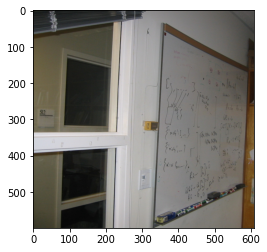

In [116]:
img = mpimg.imread('assets/board.png')
imgplot = plt.imshow(img)

Next, we apply $T_2$ to each column of the location matrix after finding the change of basis matrix using `change_of_basis_T2`.

In [117]:
# I added this, otherwise it wouldn't work below. w will be an int
w = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [118]:
# Use T2 on our specific whiteboard example
topleft = (np.array([358, 36, 1]), np.array([0, 0, 1]))
botleft = (np.array([329, 597, 1]), np.array([0, 1, 1]))
topright = (np.array([592, 157, 1]), np.array([1, 0, 1]))
botright = (np.array([580, 483, 1]), np.array([1, 1, 1]))
C = change_of_basis_T2(topleft, botleft, topright, botright)

# This is just a matrix multiplication
L_transformed = T2(C, L)

Finally, "project" onto whiteboard coordinates using $T_3$, applying the function to each of the columns of $CL$.

In [119]:
# Apply T3 column-by-column to L
L_projected = np.zeros(L_transformed.shape)
for i in range(L_transformed.shape[1]):
    L_projected[:, i] = T3(L_transformed[:, i])

In [120]:
print(L_projected)
print(L_projected.shape)

[[-0.53752609 -0.53661105 -0.53569402 ...  1.23167736  1.24010152
   1.24858011]
 [ 0.16434217  0.16394908  0.16355515 ...  1.42578711  1.42867576
   1.43158307]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
(3, 365400)


At this point, `L_projected` contains the $(w+1)(h+1)$ points of the image array after changing to the whiteboard basis and projecting down to whiteboard coordinates. Before applying $T_1, T_2, T_3$, each pixel was a square; now they are a different quadrilateral, dictated by the whiteboard basis $(\mathbf{c}_1, \mathbf{c}_2, \mathbf{c}_3)$. There are still the same number of pixels, but the new pixels' shapes are distorted according to the whiteboard basis. We assign the same $(r, g, b)$ color to the new pixels. Then, we draw each of the new pixels one by one as polygons using `matplotlib`.

In [121]:
L_board_dict = mat_to_dict(L_projected, loc_mat_keys)

In [122]:
Mx, My = color_mat_keys[-1]
vertices = []
colors = []
for pixel in color_mat_keys:
    # find four corners of the polygon
    x, y = pixel
    sx = min(x + 1, Mx) + 1
    sy = min(y + 1, My) + 1
    
    # find rgb of current pixel
    r, g, b = color_mat[pixel]
    
    # find shifted coordinates
    topleft = L_board_dict[(x,y)][:2]
    topright = L_board_dict[(sx, y)][:2]
    botleft = L_board_dict[(x, sy)][:2]
    botright = L_board_dict[(sx, sy)][:2]
    
    # draw polygon
    vert = np.array([topleft, topright, botleft, botright])
    vertices.append(vert)
    colors.append((r, g, b))

vertices = np.array(vertices)

In [123]:
vertices.shape

(364192, 4, 2)

In [124]:
vertices[0]

array([[-0.53752609,  0.16434217],
       [-0.53569402,  0.16355515],
       [-0.53739043,  0.16655215],
       [-0.535558  ,  0.16576988]])

Finally, we can see our perspective-less whiteboard!

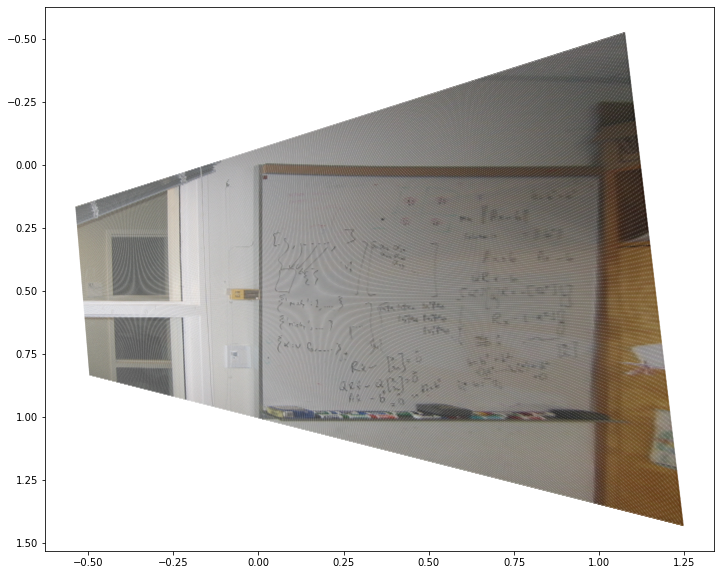

In [125]:
from matplotlib.collections import PolyCollection
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=255)
fig, ax = plt.subplots()

# Change these to make your figure bigger or smaller
fig.set_figheight(10)
fig.set_figwidth(12)

# Make the polygon collection and add it to the plot.
coll = PolyCollection(vertices, facecolors=norm(colors))
ax.add_collection(coll)
ax.autoscale_view()
ax.invert_yaxis()         # by the same reason that the wire-frame cube got flipped

plt.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [126]:
grader.check_all()

p1 results: All test cases passed!

p2 results: All test cases passed!

p3 results: All test cases passed!

p4 results: All test cases passed!

p5 results: All test cases passed!

p6 results: All test cases passed!